In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)

In [2]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
betx = 1.9065054393933862
alfx = 1.408226172730429
Nturn = np.array([128,256,512,1024])

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [13]:
TBT = {}
iTBT = {}
TBT_Inv = {}
for nturn in Nturn:
    dummy,TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    iTBT[nturn],TBT_Inv[nturn] = impact.readTBT_integral(nturn)

In [14]:
def findSameIndex(table1,index1,table2,index2):
    for i in range(len(table2)-index2+1):
        if table1[index1] == table2[index2]:
            return index2
        else:
            index2 = index2+1
    print('max_reached,index1,index2=',index1,index2,len(table1),len(table2),table1[index1],table2[index2])

In [16]:
Inv={}
initP = {}
i=0
for nturn in Nturn[1:]:
    i=i+1
    npt = len(iTBT[nturn])
    initP[nturn] = np.zeros((npt,2))
    Inv[nturn] = np.zeros((nturn,npt),dtype=np.complex)
    Inv[nturn][Nturn[i-1]:nturn,:] = TBT_Inv[nturn][:,0,:] - 1j*TBT_Inv[nturn][:,1,:]
    for j in range(i):
        k=0
        if j==0:
            nturn0 = 0
        else:
            nturn0 = Nturn[j-1]
        for ipt in range(npt):
            k = findSameIndex(iTBT[nturn],ipt,iTBT[Nturn[j]],k)
            Inv[nturn][nturn0:Nturn[j],ipt] = TBT_Inv[Nturn[j]][:,0,k] - 1j*TBT_Inv[Nturn[j]][:,1,k]
            if j ==0:
                initP[nturn][ipt,:] = TBT[Nturn[0]][0,0,k],TBT[Nturn[0]][0,2,k]

In [17]:
DiffLog = np.zeros([len(Nturn),3,npt])
iMax = {}
invH = {}
invI = {}
invA = {}
for nturn in Nturn[1:]:
    npt = len(iTBT[nturn])
    invH[nturn] = np.zeros(npt)
    invI[nturn] = np.zeros(npt)
    for ipt in range(npt):
        invH[nturn][ipt] = np.std(np.real(Inv[nturn][:,ipt]))
        invI[nturn][ipt] = np.std(np.imag(Inv[nturn][:,ipt])**2)
    invA[nturn] = np.sqrt(invH[nturn]**2+invI[nturn]**2)
    iMax[nturn] = np.argmax(invA[nturn])

# plot

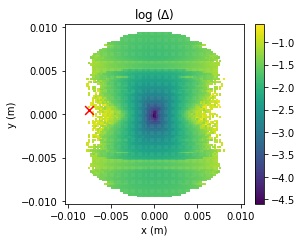

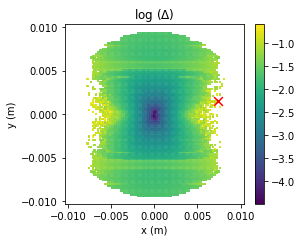

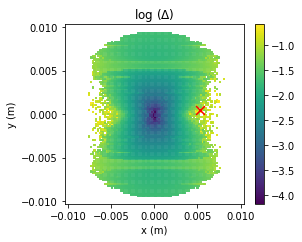

In [26]:
xmax = np.max([initP[256][:,0],initP[256][:,1]])
for nturn in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(initP[nturn][:,0],initP[nturn][:,1],c=np.log10(invA[nturn]),s=1.6,marker='s')
    plt.scatter(initP[nturn][iMax[nturn],0],initP[nturn][iMax[nturn],1],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('Inv.DA.Log.A.'+str(nturn)+'.png',dpi=180)
    # plt.close()